<a href="https://colab.research.google.com/github/Nburkhal/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [0]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [0]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=180.18849314523848, mobile=False), User(purchased=True, time_on_site=135.67700482149365, mobile=False), User(purchased=True, time_on_site=159.88535379510446, mobile=True), User(purchased=True, time_on_site=257.7835981679507, mobile=True), User(purchased=False, time_on_site=86.99445445027507, mobile=False), User(purchased=False, time_on_site=173.67358829592212, mobile=True), User(purchased=True, time_on_site=44.968058188901246, mobile=True), User(purchased=False, time_on_site=30.15219480121866, mobile=True), User(purchased=False, time_on_site=460.0007745853941, mobile=False), User(purchased=False, time_on_site=122.22911474525455, mobile=True)]


In [0]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,180.188493,False
1,True,135.677005,False
2,True,159.885354,True
3,True,257.783598,True
4,False,86.994454,False


In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.395806383057993,5.457727420381445,6.012980358659168,6.370819673044487,6.526220869482321,6.618506115477453,6.744300972093091,6.937814523764514,7.022230321283178,7.738183255456649,...,570.7205763776294,572.579212329361,573.071762294419,577.5607756708825,578.0265919014007,578.8349054472059,584.0914381586123,586.960469433746,588.7975083689481,599.8083961016524
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,0,0,0,1,1
True,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,1,1,0,0


In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.801, 124.278]","(124.278, 243.161]","(243.161, 362.043]","(362.043, 480.926]","(480.926, 599.808]"
purchased,,,,,
False,240,233,105,29,28
True,96,131,102,20,16


In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.801, 124.278]","(124.278, 243.161]","(243.161, 362.043]","(362.043, 480.926]","(480.926, 599.808]"
purchased,,,,,
False,0.714286,0.64011,0.507246,0.591837,0.636364
True,0.285714,0.35989,0.492754,0.408163,0.363636


In [0]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.672,0.622667
True,0.328,0.377333


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

# Import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('fivethirtyeight')

# Get raw data from web
people_data = 'https://raw.githubusercontent.com/SeanAntosiak/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv'


# Create pandas dataframe
df = pd.read_csv(people_data)
df.head()

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [0]:
# Drop Unnamed: 0 column since it's the same as the index
df = df.drop('Unnamed: 0', axis=1)
df.head()

,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


In [0]:
# Check for null values and data types
df.isna().sum(), df.dtypes

(age              0
 weight           0
 exercise_time    0
 dtype: int64, age              int64
 weight           int64
 exercise_time    int64
 dtype: object)

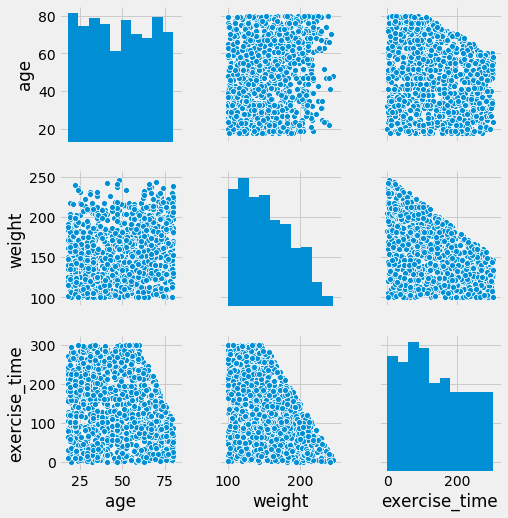

In [0]:
# Check for relationships between data

# Seaborn pairplot
sns.pairplot(df);

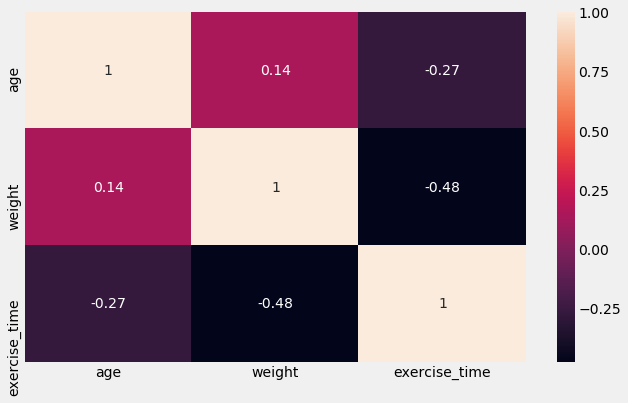

In [0]:
# Seaborn correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True)
plt.plot();

In [0]:
# Get descriptive statistics of data
df.describe()

,age,weight,exercise_time
count,1200.000000,1200.000000,1200.000000
mean,48.396667,153.540833,134.910833
std,18.166802,35.132182,85.548895
min,18.000000,100.000000,0.000000
25%,33.000000,125.000000,65.000000
50%,48.000000,149.000000,122.000000
75%,64.000000,180.250000,206.000000
max,80.000000,246.000000,300.000000


In [0]:
# downgrade pandas to v0.23.4
!pip install pandas==0.23.4

     |████████████████████████████████| 8.9MB 683kB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=0.24.0, but you'll have pandas 0.23.4 which is incompatible.
  Found existing installation: pandas 0.24.2
    Uninstalling pandas-0.24.2:
      Successfully uninstalled pandas-0.24.2


In [0]:
# Cross-tabulate to get a better understanding of the data

# Create evenly-distributed time bins
time_bins = pd.cut(df['exercise_time'], 5)  # equal-sized bins

# Create bins for age based on specified range
age_bins = pd.cut(df['age'], [17, 24, 34, 44, 54, 64, 74, 80])

# Create evenly-distributed weight bins
weight_bins = pd.cut(df['weight'], 8)  # equal sized bins

ct = pd.crosstab([age_bins, weight_bins], time_bins, normalize='index')
ct

exercise_time              (-0.3, 60.0]       ...        (240.0, 300.0]
age      weight                               ...                      
(17, 24] (99.854, 118.25]      0.115385       ...              0.269231
         (118.25, 136.5]       0.130435       ...              0.217391
         (136.5, 154.75]       0.080000       ...              0.040000
         (154.75, 173.0]       0.035714       ...              0.071429
         (173.0, 191.25]       0.400000       ...              0.000000
         (191.25, 209.5]       0.230769       ...              0.000000
         (209.5, 227.75]       0.500000       ...              0.000000
         (227.75, 246.0]       1.000000       ...              0.000000
(24, 34] (99.854, 118.25]      0.113208       ...              0.339623
         (118.25, 136.5]       0.052632       ...              0.421053
         (136.5, 154.75]       0.195652       ...              0.239130
         (154.75, 173.0]       0.235294       ...              0.117647
         (173.0, 191.25]       0.235294       ...              0.000000
         (191.25, 209.5]       0.636364       ...              0.000000
         (209.5, 227.75]       0.846154       ...              0.000000
         (227.75, 246.0]       1.000000       ...              0.000000
(34, 44] (99.854, 118.25]      0.068182       ...              0.295455
         (118.25, 136.5]       0.066667       ...              0.400000
         (136.5, 154.75]       0.161290       ...              0.290323
         (154.75, 173.0]       0.142857       ...              0.285714
         (173.0, 191.25]       0.250000       ...              0.000000
         (191.25, 209.5]       0.473684       ...              0.000000
         (209.5, 227.75]       0.857143       ...              0.000000
         (227.75, 246.0]       1.000000       ...              0.000000
(44, 54] (99.854, 118.25]      0.161290       ...              0.451613
         (118.25, 136.5]       0.076923       ...              0.564103
         (136.5, 154.75]       0.074074       ...              0.444444
         (154.75, 173.0]       0.160000       ...              0.120000
         (173.0, 191.25]       0.277778       ...              0.000000
         (191.25, 209.5]       0.333333       ...              0.000000
         (209.5, 227.75]       0.444444       ...              0.000000
         (227.75, 246.0]       1.000000       ...              0.000000
(54, 64] (99.854, 118.25]      0.172414       ...              0.241379
         (118.25, 136.5]       0.050000       ...              0.275000
         (136.5, 154.75]       0.157895       ...              0.236842
         (154.75, 173.0]       0.076923       ...              0.076923
         (173.0, 191.25]       0.280000       ...              0.000000
         (191.25, 209.5]       0.190476       ...              0.000000
         (209.5, 227.75]       0.461538       ...              0.000000
         (227.75, 246.0]       1.000000       ...              0.000000
(64, 74] (99.854, 118.25]      0.296296       ...              0.000000
         (118.25, 136.5]       0.264706       ...              0.029412
         (136.5, 154.75]       0.178571       ...              0.000000
         (154.75, 173.0]       0.236842       ...              0.000000
         (173.0, 191.25]       0.233333       ...              0.000000
         (191.25, 209.5]       0.478261       ...              0.000000
         (209.5, 227.75]       0.461538       ...              0.000000
         (227.75, 246.0]       1.000000       ...              0.000000
(74, 80] (99.854, 118.25]      0.333333       ...              0.000000
         (118.25, 136.5]       0.461538       ...              0.000000
         (136.5, 154.75]       0.277778       ...              0.000000
         (154.75, 173.0]       0.416667       ...              0.000000
         (173.0, 191.25]       0.416667       ...              0.000000
         (191.25, 209.5]       0.461538 

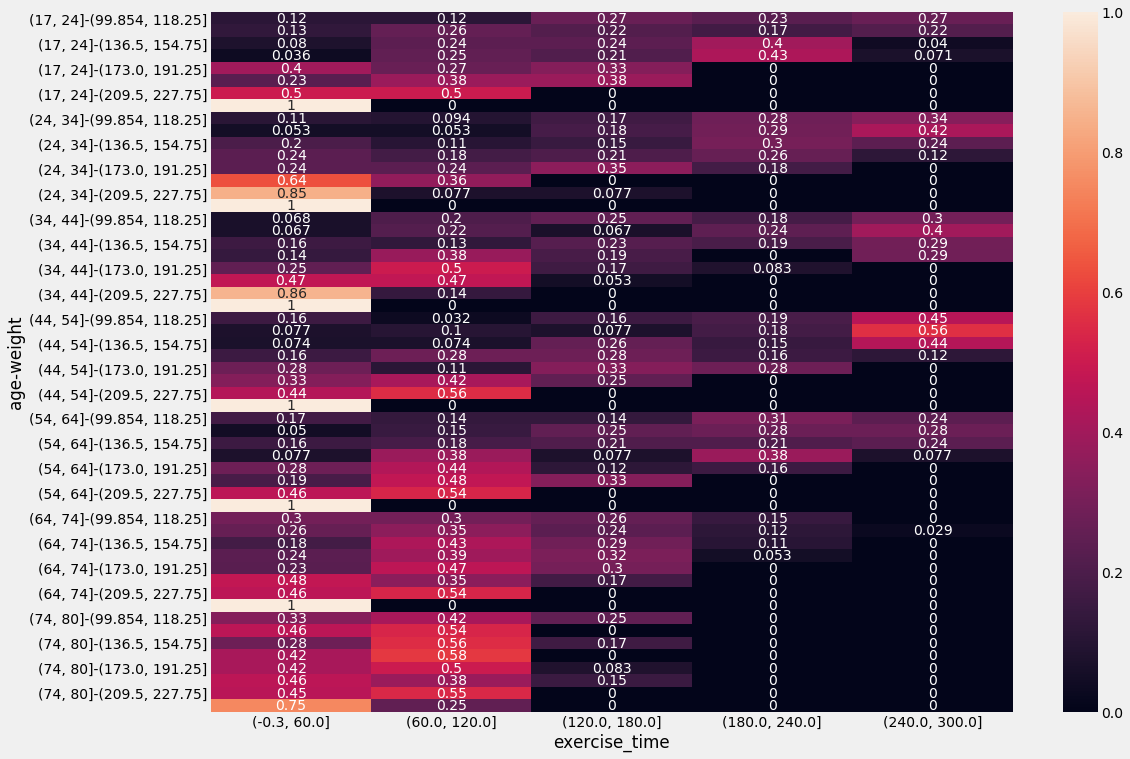

In [0]:
plt.figure(figsize=(16,12))
sns.heatmap(ct, annot=True)
plt.show();

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)